In [80]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
import re
from typing import Optional
import numpy as np
from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

In [81]:
pwd

'/kaggle/working'

In [82]:
filename = '/kaggle/input/code_comments/data/data/test.json'
#chemin actuel du fichier

# Lire et décoder chaque ligne JSON individuellement
data = []
with open(filename) as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Erreur lors du décodage de la ligne : {e}")

# Afficher les 5 premiers éléments du fichier JSON
for i in data[:5]:
    print(i)

{'code': 'public static String unEscapeString(String str,char escapeChar,char charToEscape){\n  return unEscapeString(str,escapeChar,new char[]{charToEscape});\n}\n', 'nl': 'Unescape <code>charToEscape</code> in the string with the escape char <code>escapeChar</code>'}
{'code': 'public void checkNextPoissonConsistency(double mean){\n  final int sampleSize=1000;\n  final int minExpectedCount=7;\n  long maxObservedValue=0;\n  final double alpha=0.001;\n  UnitTestUtils.Frequency<Long> frequency=new UnitTestUtils.Frequency<Long>();\n  for (int i=0; i < sampleSize; i++) {\n    long value=randomData.nextPoisson(mean);\n    if (value > maxObservedValue) {\n      maxObservedValue=value;\n    }\n    frequency.addValue(value);\n  }\n  PoissonDistribution poissonDistribution=new PoissonDistribution(mean);\n  int lower=1;\n  while (poissonDistribution.cumulativeProbability(lower - 1) * sampleSize < minExpectedCount) {\n    lower++;\n  }\n  int upper=(int)(5 * mean);\n  while ((1 - poissonDistribut

In [83]:
def jsonl_to_dataframe(file_path, columns=['code', 'nl']):
    """Telechargement du JSON lignes file dans pandas DataFrame."""
    df = pd.read_json(file_path, orient='records', lines=True)
    return df[columns]

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """convertir les differents data splits en dataframe pandas"""
    #path est le chemin du folder qui stocke les differents splits de types json il est de type Path
    dfs = []
    for split in ["train.json", "valid.json", "test.json"]:
        file_path = path / split
        if not file_path.exists():
            print(f"File not found: {file_path}")
            dfs.append(pd.DataFrame(columns=['mthd', 'cmt']))  # Créer un DataFrame vide pour ce split
        else:
            df = jsonl_to_dataframe(file_path)
            df = df.rename(columns={'code': 'mthd', 'nl': 'cmt'})
            dfs.append(df)

    return dfs

# Chemin vers les fichiers
path = Path('/kaggle/input/code_comments/data/data')

# Charger les DataFrames
df_trn, df_val, df_tst = get_dfs(path)

#afficher la taille avant l'echantillonage
print(len(df_trn), len(df_val), len(df_tst))

# Échantillonner les DataFrames pour reduire la quantite des donnees originaux dans les dataframes
sample = 0.008
df_trn = df_trn.sample(frac=sample) if not df_trn.empty else df_trn
df_val = df_val.sample(frac=sample) if not df_val.empty else df_val
df_tst = df_tst.sample(frac=sample) if not df_tst.empty else df_tst

# Afficher les tailles des DataFrames échantillonnés
print(len(df_trn), len(df_val), len(df_tst))

470486 58811 58811
3764 470 470


In [84]:
df_trn.head()

,mthd,cmt
283228,public boolean isMember(int x){\n Assert.chec...,Is x an element of this set?
393934,"@Override public void eSet(int featureID,Objec...",<!-- begin-user-doc --> <!-- end-user-doc -->
218074,"public void add(char[] w,int wLen){\n if (i +...",Adds wLen characters to the word being stemmed...
163714,public boolean canRedo(){\n return undoManage...,Tells whether a redo is possible
20795,public void testNextIntBounded(){\n for (int ...,nextInt(bound) returns 0 <= value < bound; rep...


In [85]:
#data cleaning
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if une chaine donnee contient que les ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii') # encode(encoding='utf-8') : Cette méthode convertit la chaîne s en un format binaire (bytes) en utilisant l'encodage UTF-8
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(3764, 470, 470)

In [30]:
# Charger le DataFrame
path = Path('/kaggle/input/code_comments/data/data/train.json')
df = jsonl_to_dataframe(path)

# Identifier les valeurs manquantes
missing_values = df.isna()
print("DataFrame des valeurs manquantes :")
print(missing_values)

#la somme des valeurs manquantes par colonne
missing_values_sum = df.isna().sum()
print("\nNombre de valeurs manquantes par colonne :")
print(missing_values_sum)

# le nombre total de valeurs manquantes
total_missing_values = df.isna().sum().sum()
print("\nNombre total de valeurs manquantes :")
print(total_missing_values)

DataFrame des valeurs manquantes :
         code     nl
0       False  False
1       False  False
2       False  False
3       False  False
4       False  False
...       ...    ...
470481  False  False
470482  False  False
470483  False  False
470484  False  False
470485  False  False

[470486 rows x 2 columns]

Nombre de valeurs manquantes par colonne :
code    0
nl      0
dtype: int64

Nombre total de valeurs manquantes :
0


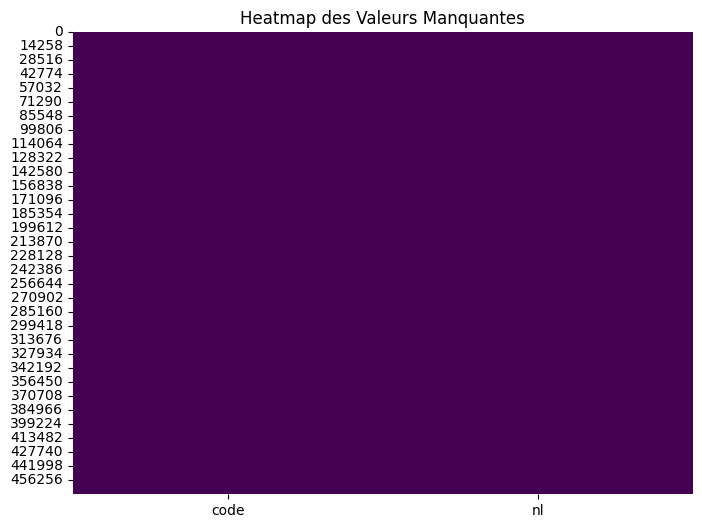

In [86]:
# Afficher un heatmap des valeurs manquantes
plt.figure(figsize=(8, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap des Valeurs Manquantes")
plt.show()

In [87]:
def has_code(cmt: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param cmt: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in cmt: return True
    else: return False

df_trn = df_trn[~df_trn['cmt'].apply(lambda x: has_code(x))]
df_val = df_val[~df_val['cmt'].apply(lambda x: has_code(x))]
df_tst = df_tst[~df_tst['cmt'].apply(lambda x: has_code(x))]

len(df_trn), len(df_val), len(df_tst)

(3595, 414, 450)

In [88]:
def clean_html(cmt: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param cmt: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)
    return result

df_trn.cmt = df_trn.cmt.apply(clean_html)
df_val.cmt = df_val.cmt.apply(clean_html)
df_tst.cmt = df_tst.cmt.apply(clean_html)

In [89]:

df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

/tmp/ipykernel_788/3057737639.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_788/3057737639.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_788/3057737639.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())


(3357, 401, 433)

In [90]:
# Afficher le résumé statistique
print("Résumé statistique :")
print(df.describe())

Résumé statistique :
                                                     code  \
count                                              470486   
unique                                             389173   
top     private void returnData(Object ret){\n  if (my...   
freq                                                 1284   

                                                   nl  
count                                          470486  
unique                                         300314  
top     <!-- begin-user-doc --> <!-- end-user-doc -->  
freq                                             7604  


In [91]:
# collapse
from tqdm import tqdm
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["cmt"]
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)


        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["mthd"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_jdocs(df_trn);
df_val = remove_jdocs(df_val);
df_tst = remove_jdocs(df_tst);

100%|██████████| 433/433 [00:00<00:00, 63561.18it/s]


In [92]:
df_trn.head()

,mthd,cmt
0,public boolean ismember(int x){ assert.check(c...,is x an element of this set?
1,"@override public void eset(int featureid,objec...",<!-- begin-user-doc --> <!-- end-user-doc -->
2,"public void add(char[] w,int wlen){ if (i + wl...",adds wlen characters to the word being stemmed...
3,public boolean canredo(){ return undomanager.c...,tells whether a redo is possible
4,public void testnextintbounded(){ for (int bou...,nextint(bound) returns 0 <= value < bound; rep...


In [93]:
len(df_trn)

3357

In [94]:
def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: Un dataframe de type Pandas
    :param tokenizer: Un tokenizer de type Autotokenizer
    dataframe
    :param col: Une chaine de type string indiquant la colonne du dataframe a analyser
    :returns: Le nombre des occurences de chaque token dans la colonne specifiee
       '''
    toks = []
    for i, row in df.iterrows():
      #df.iterrows() retourne un générateur qui produit des paires (index de la ligne, données de la ligne sous forme de série pandas).
        toks.extend(tokenizer.tokenize(row[col]))

    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base') #Chargement d'un tokenizer pré-entraîné basé sur le modèle microsoft/codebert-base de Hugging Face.
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values #Cette méthode (values) extrait les données de la série pandas sous forme de tableau NumPy (array).
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95)) #Calcul des longueurs maximales à 95% (quantiles) c'est-à-dire la valeur en dessous de laquelle se situent 95% des longueurs de tokens
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


In [95]:
# collapse
def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    :param counts: conteur des tokens et de leurs frequences
    :param top_k: le nombre de token a afficher dans le plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

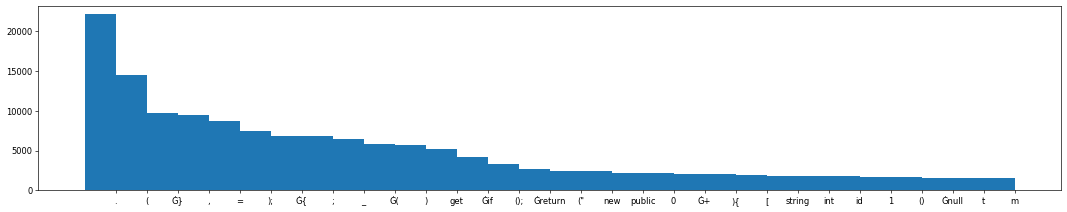

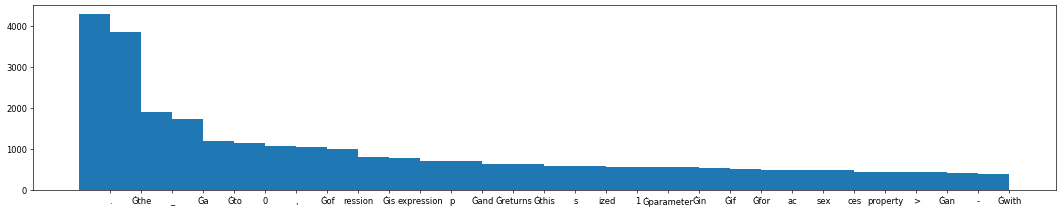

In [96]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [97]:
# Calcul des statistiques descriptives pour les longueurs des tokens
def descriptive_stats(lengths):
    return {
        'mean': np.mean(lengths), #moyenne
        'median': np.median(lengths), #mediane
        'std_dev': np.std(lengths), #ecart_type
        'min': np.min(lengths),
        'max': np.max(lengths),
        '25th_percentile': np.percentile(lengths, 25), #premier quartile (Q1)
        '75th_percentile': np.percentile(lengths, 75) #troisième quartile (Q3)
    }

mthd_stats = descriptive_stats(mthd_lens)
cmt_stats = descriptive_stats(cmt_lens)

print("Method Lengths Statistics:", mthd_stats)
print("Comment Lengths Statistics:", cmt_stats)


Method Lengths Statistics: {'mean': 128.65207030086387, 'median': 61.0, 'std_dev': 241.11868142855116, 'min': 4, 'max': 4987, '25th_percentile': 28.0, '75th_percentile': 134.0}
Comment Lengths Statistics: {'mean': 22.949359547214776, 'median': 12.0, 'std_dev': 202.97544750065575, 'min': 2, 'max': 10997, '25th_percentile': 8.0, '75th_percentile': 21.0}


In [98]:
print("Top Tokens in Methods:", mthd_cnt.most_common(30))
print("Top Tokens in Comments:", cmt_cnt.most_common(30))

Top Tokens in Methods: [('.', 22066), ('(', 14510), ('Ġ}', 9658), (',', 9461), ('=', 8740), (');', 7415), ('Ġ{', 6852), (';', 6825), ('_', 6447), ('Ġ(', 5794), (')', 5692), ('get', 5209), ('Ġif', 4147), ('();', 3353), ('Ġreturn', 2736), ('("', 2474), ('new', 2445), ('public', 2178), ('0', 2160), ('Ġ+', 2113), ('){', 2013), ('[', 1884), ('string', 1866), ('int', 1770), ('id', 1745), ('1', 1711), ('()', 1670), ('Ġnull', 1583), ('t', 1530), ('m', 1526)]
Top Tokens in Comments: [('.', 4291), ('Ġthe', 3863), ('_', 1898), ('Ġa', 1738), ('Ġto', 1194), ('0', 1145), (',', 1074), ('Ġof', 1066), ('ression', 1003), ('Ġis', 823), ('expression', 786), ('p', 726), ('Ġand', 715), ('Ġreturns', 649), ('Ġthis', 646), ('s', 598), ('ized', 584), ('1', 579), ('Ġparameter', 565), ('Ġin', 559), ('Ġif', 542), ('Ġfor', 531), ('ac', 491), ('sex', 485), ('ces', 483), ('property', 447), ('>', 442), ('Ġan', 438), ('-', 424), ('Ġwith', 394)]


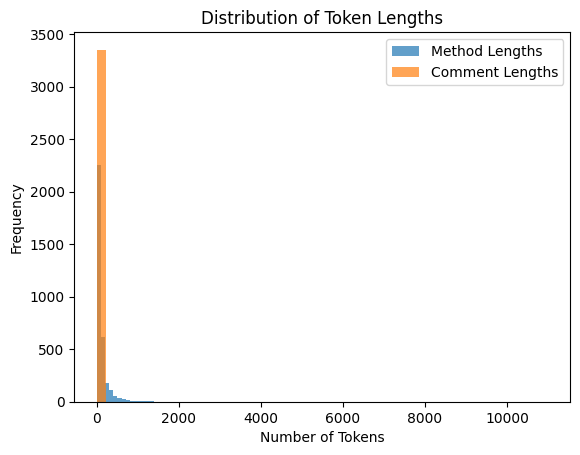

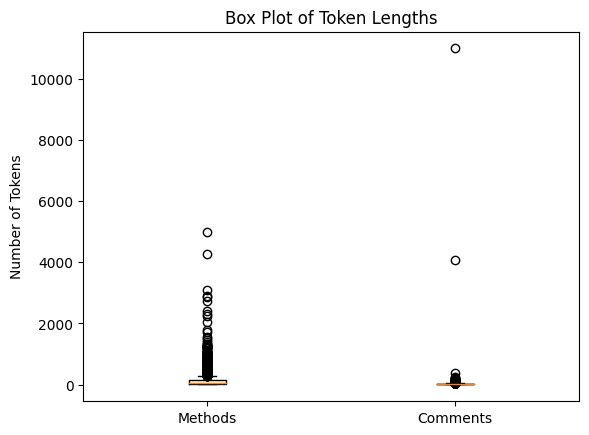

In [99]:
# Histogramme
plt.hist(mthd_lens, bins=50, alpha=0.7, label='Method Lengths')
plt.hist(cmt_lens, bins=50, alpha=0.7, label='Comment Lengths')
plt.legend()
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

# Box Plot
plt.boxplot([mthd_lens, cmt_lens], labels=['Methods', 'Comments'])
plt.ylabel('Number of Tokens')
plt.title('Box Plot of Token Lengths')
plt.show()

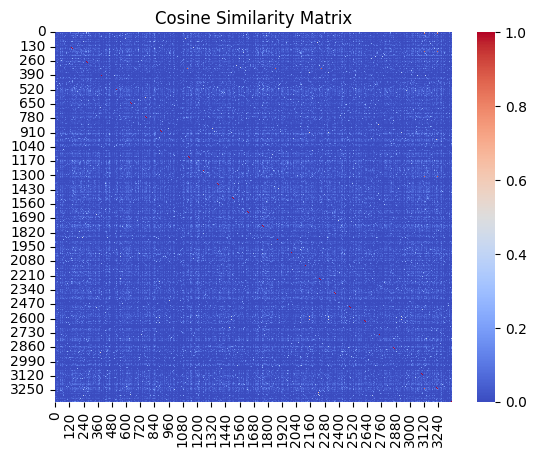

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Calcul de la similarité cosinus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_trn['cmt'])
similarity_matrix = cosine_similarity(X)

# Affichage de la matrice de similarité
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title('Cosine Similarity Matrix')
plt.show()

## **Model** 

Maintenant nous allons charger le model et le tokenizer pour le Bart pre-entraine

In [102]:
from transformers import BartForConditionalGeneration,Seq2SeqTrainer,Seq2SeqTrainingArguments,BartTokenizer

# Chargement du du tokenizer spécifique à bart
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Chargement du modèle pré-entraîné bart
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [104]:
!mkdir java

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: cannot create directory 'java': File exists


In [48]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


java  results  wandb


In [105]:
import json

df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split()) #Ajouter une nouvelle colonne des tokens au dataframe
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open('java/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n') #Convertir les row en dictionnaire puis pour l'ecriture dans le fichier json il faut avoir un format chaine de caractere c'est le role de dump

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open('java/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open('java/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

Ce code a pour but la transformation des dataframes en fichier de type json ligne qui est le format convenable pour l'entrainement de notre model

In [107]:
from datasets import load_dataset
# Spécifiez notre dataset
data_dir = '.'
lang = 'java'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
test_file = f'{data_dir}/{lang}/test.jsonl'

# Charger les datasets depuis les fichiers JSONL
train_dataset = load_dataset('json', data_files=train_file, split='train')
eval_dataset = load_dataset('json', data_files=dev_file, split='train')
test_dataset = load_dataset('json', data_files=test_file, split='train')

# Fonction de tokenisation
def tokenize_function(examples):
    inputs = tokenizer(examples['mthd'], padding="max_length", truncation=True, max_length=256)
    labels = tokenizer(examples['cmt'], padding="max_length", truncation=True, max_length=50)
    inputs['labels'] = labels['input_ids']
    return inputs

# Appliquer la tokenisation aux datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

La tokenisation des jeux de donnees jsonl par la fonction **tokenize_function** telle que cette tokenisation sera appliquee avec des batches, qui rend la tokenisation plus efficace, pour préparer un modèle **Seq2Seq** (du Bart) à être entraîné.

Maintenant nous allons faire la Configuration des parametres necessaires pour l'entrainement du model 

In [127]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  
    save_strategy="epoch",        
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.02,
    save_total_limit=3,
    gradient_accumulation_steps=2,
    load_best_model_at_end=True
)


In [32]:
!pip install wandb

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Ici nous allons commencer l'entainement de notre model en utilisant le model pre entraine seq2seq des transformers de hugging face**

In [128]:
# Configuration du Trainer avec bart
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)
# Entraînez le modèle
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,No log,1.330122
2,No log,1.354675
3,No log,1.379515
4,No log,1.415574
5,0.600700,1.423160
6,0.600700,1.446667
7,0.600700,1.461602
8,0.600700,1.480612
9,0.600700,1.483141
10,0.468300,1.490314


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in 

TrainOutput(global_step=1050, training_loss=0.5302036612374442, metrics={'train_runtime': 927.8141, 'train_samples_per_second': 36.182, 'train_steps_per_second': 1.132, 'total_flos': 5117213225779200.0, 'train_loss': 0.5302036612374442, 'epoch': 10.0})

**Maintenant nous allons effectuer une evaluation du modele que nous avons entrainer**

In [129]:
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.330122470855713, 'eval_runtime': 4.3103, 'eval_samples_per_second': 93.033, 'eval_steps_per_second': 6.032, 'epoch': 10.0}


In [130]:
#test_results = trainer.evaluate(eval_dataset=test_dataset)
#print(test_results)

{'eval_loss': 1.2973840236663818, 'eval_runtime': 4.0999, 'eval_samples_per_second': 105.613, 'eval_steps_per_second': 6.829, 'epoch': 10.0}


Maintenant nous allons definir la fonction pour la genaration des commentaire 

In [132]:
import torch

# Définir le périphérique avec le quel on va travailler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Charger le modèle sur le périphérique
model.to(device)

def generate_comment(code):
    # Tokeniser l'entrée et déplacer les tensors sur le périphérique
    inputs = tokenizer(code, return_tensors='pt').to(device)
    
    # Générer des commentaires avec le modèle
    outputs = model.generate(**inputs)
    
    # Décoder le texte généré
    comment = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return comment

In [142]:
print(df_tst.columns)


Index(['mthd', 'cmt', 'code_tokens', 'docstring_tokens'], dtype='object')


In [70]:
# Supprimer les colonnes d'index qui peuvent causer des conflits
df_tst = df_tst.drop(columns=['level_0', 'index'], errors='ignore')

# Réinitialiser l'index
df_tst = df_tst.reset_index(drop=True)


**Maintenant affichant les 10 premieres predictions de test**

In [144]:
# Définir la fonction pour vérifier si les commentaires correspondent exactement
def exact_match(predicted, actual):
    return predicted.strip() == actual.strip()

# Itérer sur les 10 premières lignes du DataFrame pour générer les commentaires
df_tst = df_tst.reset_index(drop=True)
preds = []
actual_comments = df_tst.head(10)['cmt'].tolist()  # Extraire les commentaires originaux

for idx, row in df_tst.head(10).iterrows():
    generated_comment = generate_comment(row.mthd)  # Générer un commentaire pour chaque ligne
    preds.append(generated_comment.strip())

    # Afficher les résultats pour chaque ligne
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', generated_comment)
    print('='*40)

Code: @override public void flush(){ }
Original Comment: flushing this writer has no effect.
Generated Comment: flushes this stream.
Code: private string resolveloggerproperty(logmanager manager,string property){ string propertykey=handler_prop_prefix + property; return system.getproperty(propertykey,manager.getproperty(propertykey)); }
Original Comment: resolve logger property by its name - system property value if available, or logger property extracted from the log configuration.
Generated Comment: returns a string describing the logmanager property.
Code: public static byte[] writeltriad(int triad){ byte b1, b2, b3; b3=(byte)(triad & 0xff); b2=(byte)((triad >> 8) & 0xff); b1=(byte)((triad >> 16) & 0xff); return new byte[]{b3,b2,b1}; }
Original Comment: writes a 3-byte little-endian number
Generated Comment: writes a triad byte array to a byte array.
Code: @override protected void oncreate(bundle savedinstancestate){ super.oncreate(savedinstancestate); overridependingtransition(0,0)

## **Evaluation du modele**

**Calculons le Bleu score**

In [145]:
from nltk.translate.bleu_score import sentence_bleu

# Exemple pour calculer le score BLEU
bleu_scores = []

for pred, real in zip(preds, actual_comments):
    # Tokeniser les phrases
    pred_tokens = pred.split()
    real_tokens = real.split()
    score = sentence_bleu([real_tokens], pred_tokens)
    bleu_scores.append(score)

# Calculer la moyenne des scores BLEU
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu:.2f}")


Average BLEU Score: 0.23


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**Interpretation du score:**
Un score BLEU moyen de 0,23 indique une correspondance modérée entre les commentaires générés par le modèle et les commentaires de référence, suggérant que le modèle saisit partiellement le contenu attendu

Maintenant nous allons calculer les pertes d'informations entre les commentaires generes et ceux originaux

In [148]:
# Filtrer df_val pour n'inclure que les 10 premières lignes
df_val_filtered = df_val.head(10).copy()

# Ajouter les prédictions et les pertes au DataFrame filtré
df_val_filtered['pred'] = preds
df_val_filtered['loss'] = losses

# Trier le DataFrame filtré par la colonne 'loss'
df_sorted_losses = df_val_filtered.sort_values(by='loss', ascending=True)

# Afficher les résultats triés par perte
for _, row in df_sorted_losses.iterrows():
    print('Code:', row['mthd'])
    print('Original Comment:', row['cmt'])
    print('Generated Comment:', row['pred'])
    print('Loss:', row['loss'])
    print('='*40)


Code: public static string verifycertificate(x509certificate cert,collection<crl> crls,calendar calendar){ if (signutils.hasunsupportedcriticalextension(cert)) return "has unsupported critical extension"; try { cert.checkvalidity(calendar.gettime()); } catch ( exception e) { return e.getmessage(); } if (crls != null) { for ( crl crl : crls) { if (crl.isrevoked(cert)) return "certificate revoked"; } } return null; }
Original Comment: verifies a single certificate.
Generated Comment: prints a space character.
Loss: 0.3525408721163361
Code: public boolean isvalid(){ return mode != null && eclevel != null && version != -1 && matrixwidth != -1 && maskpattern != -1 && numtotalbytes != -1 && numdatabytes != -1 && numecbytes != -1 && numrsblocks != -1 && isvalidmaskpattern(maskpattern) && numtotalbytes == numdatabytes + numecbytes && matrix != null && matrixwidth == matrix.getwidth() && matrix.getwidth() == matrix.getheight(); }
Original Comment: check the validity of all member variables
Gene

On calculera par la suite la moyenne des pertes des 10 premiers exemples

In [149]:
# Calcule de perte totale
total_loss = sum(losses)

print(f"Total Loss: {total_loss:.2f}")


Total Loss: 7.25


## Evaluation avec des exemples humains

In [146]:
# Extrait de code pour le test
code_example = """def add(a, b):
    return a + b"""

# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu (remplacez par un commentaire réel pour comparaison)
real_comment = "This function adds two numbers and returns the result."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")


Code:
def add(a, b):
    return a + b

Generated Comment:
adds b to the end of the array.

Original Comment:
This function adds two numbers and returns the result.



In [147]:
code_example = """def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True"""
# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu (remplacez par un commentaire réel pour comparaison)
real_comment = "This function checks if a number is prime by testing divisibility from 2 to the square root of the number."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")

Code:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

Generated Comment:
returns true if n <= 1, and false otherwise

Original Comment:
This function checks if a number is prime by testing divisibility from 2 to the square root of the number.



# Fin

Apres ces exemples qu'on a utiliser on voit tres bien que le modèle BART semble avoir des difficultés à comprendre le contexte complet du code source, générant des commentaires qui sont soit incorrects, soit partiels, ce qui indique une limitation dans sa capacité à interpréter correctement la logique du code.